# Library

In [1]:
import time, os, sys, math
import cv2
import numpy as np
from time import time
from scipy.io import savemat
import argparse
import imageio
from skimage.transform import rescale
import torch
import matplotlib.pyplot as plt
import h5py 
from pathlib import Path
import pandas as pd 

from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.rotation_converter import batch_euler2axis, deg2rad
from decalib.utils.config import cfg as deca_cfg

import os, sys
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
from time import time
from skimage.io import imread
import cv2
import pickle
sys.path.insert(0, os.path.join(os.getcwd(), 'decalib'))
from decalib.utils.renderer import SRenderY
from decalib.models.encoders import ResnetEncoder
from decalib.models.FLAME import FLAME, FLAMETex
from decalib.models.decoders import Generator
from decalib.utils import util
from decalib.utils.rotation_converter import batch_euler2axis
from decalib.datasets import datasets
from decalib.utils.config import cfg
torch.backends.cudnn.benchmark = True

import scipy.io as io
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import Dataset, TensorDataset
import torchvision.transforms as transforms

import argparse
from matplotlib import cm
from sklearn.decomposition import PCA

/home/ubuntu/anaconda3/envs/syn-torch1.10.1/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper

In [2]:
def show_img(img):
  plt.imshow(img)
  plt.show()

def show_img_final(img, savename):
  plt.imshow(img)
  plt.axis('off')
  plt.savefig(savename, bbox_inches='tight')
  plt.show()

# DECA 

In [3]:
class DECA(object):
    def __init__(self, config=None, device='cuda'):
        if config is None:
            self.cfg = cfg
        else:
            self.cfg = config
        self.device = device
        self.image_size = self.cfg.dataset.image_size
        self.uv_size = self.cfg.model.uv_size

        self._create_model(self.cfg.model)
        self._setup_renderer(self.cfg.model)

    def _setup_renderer(self, model_cfg):
        # self.render = SRenderY(self.image_size, obj_filename=model_cfg.topology_path, uv_size=model_cfg.uv_size).to(self.device)
        self.render = SRenderY(self.image_size, obj_filename=model_cfg.topology_path, uv_size=model_cfg.uv_size).to(self.device)
        # face mask for rendering details
        mask = imread(model_cfg.face_eye_mask_path).astype(np.float32)/255.; mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
        self.uv_face_eye_mask = F.interpolate(mask, [model_cfg.uv_size, model_cfg.uv_size]).to(self.device)
        mask = imread(model_cfg.face_mask_path).astype(np.float32)/255.; mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
        self.uv_face_mask = F.interpolate(mask, [model_cfg.uv_size, model_cfg.uv_size]).to(self.device)
        # displacement correction
        fixed_dis = np.load(model_cfg.fixed_displacement_path)
        self.fixed_uv_dis = torch.tensor(fixed_dis).float().to(self.device)
        # mean texture
        mean_texture = imread(model_cfg.mean_tex_path).astype(np.float32)/255.; mean_texture = torch.from_numpy(mean_texture.transpose(2,0,1))[None,:,:,:].contiguous()
        self.mean_texture = F.interpolate(mean_texture, [model_cfg.uv_size, model_cfg.uv_size]).to(self.device)
        # dense mesh template, for save detail mesh
        self.dense_template = np.load(model_cfg.dense_template_path, allow_pickle=True, encoding='latin1').item()

    def _create_model(self, model_cfg):
        # set up parameters
        self.n_param = model_cfg.n_shape+model_cfg.n_tex+model_cfg.n_exp+model_cfg.n_pose+model_cfg.n_cam+model_cfg.n_light
        self.n_detail = model_cfg.n_detail
        self.n_cond = model_cfg.n_exp + 3 # exp + jaw pose
        self.num_list = [model_cfg.n_shape, model_cfg.n_tex, model_cfg.n_exp, model_cfg.n_pose, model_cfg.n_cam, model_cfg.n_light]
        self.param_dict = {i:model_cfg.get('n_' + i) for i in model_cfg.param_list}

        # encoders
        self.E_flame = ResnetEncoder(outsize=self.n_param).to(self.device) 
        self.E_detail = ResnetEncoder(outsize=self.n_detail).to(self.device)
        # decoders
        self.flame = FLAME(model_cfg).to(self.device)
        if model_cfg.use_tex:
            self.flametex = FLAMETex(model_cfg).to(self.device)
        self.D_detail = Generator(latent_dim=self.n_detail+self.n_cond, out_channels=1, out_scale=model_cfg.max_z, sample_mode = 'bilinear').to(self.device)
        # resume model
        model_path = self.cfg.pretrained_modelpath
        if os.path.exists(model_path):
            print(f'trained model found. load {model_path}')
            checkpoint = torch.load(model_path)
            self.checkpoint = checkpoint
            util.copy_state_dict(self.E_flame.state_dict(), checkpoint['E_flame'])
            util.copy_state_dict(self.E_detail.state_dict(), checkpoint['E_detail'])
            util.copy_state_dict(self.D_detail.state_dict(), checkpoint['D_detail'])
        else:
            print(f'please check model path: {model_path}')
            exit()
        # eval mode
        self.E_flame.eval()
        self.E_detail.eval()
        self.D_detail.eval()

    def decompose_code(self, code, num_dict):
        ''' Convert a flattened parameter vector to a dictionary of parameters
        code_dict.keys() = ['shape', 'tex', 'exp', 'pose', 'cam', 'light']
        '''
        code_dict = {}
        start = 0
        for key in num_dict:
            end = start+int(num_dict[key])
            code_dict[key] = code[:, start:end]
            start = end
            if key == 'light':
                code_dict[key] = code_dict[key].reshape(code_dict[key].shape[0], 9, 3)
        return code_dict

    def displacement2normal(self, uv_z, coarse_verts, coarse_normals):
        ''' Convert displacement map into detail normal map
        '''
        batch_size = uv_z.shape[0]
        uv_coarse_vertices = self.render.world2uv(coarse_verts).detach()
        uv_coarse_normals = self.render.world2uv(coarse_normals).detach()
    
        uv_z = uv_z*self.uv_face_eye_mask
        uv_detail_vertices = uv_coarse_vertices + uv_z*uv_coarse_normals + self.fixed_uv_dis[None,None,:,:]*uv_coarse_normals.detach()
        dense_vertices = uv_detail_vertices.permute(0,2,3,1).reshape([batch_size, -1, 3])
        uv_detail_normals = util.vertex_normals(dense_vertices, self.render.dense_faces.expand(batch_size, -1, -1))
        uv_detail_normals = uv_detail_normals.reshape([batch_size, uv_coarse_vertices.shape[2], uv_coarse_vertices.shape[3], 3]).permute(0,3,1,2)
        return uv_detail_normals

    def displacement2vertex(self, uv_z, coarse_verts, coarse_normals):
        ''' Convert displacement map into detail vertices
        '''
        batch_size = uv_z.shape[0]
        uv_coarse_vertices = self.render.world2uv(coarse_verts).detach()
        uv_coarse_normals = self.render.world2uv(coarse_normals).detach()
    
        uv_z = uv_z*self.uv_face_eye_mask
        uv_detail_vertices = uv_coarse_vertices + uv_z*uv_coarse_normals + self.fixed_uv_dis[None,None,:,:]*uv_coarse_normals.detach()
        dense_vertices = uv_detail_vertices.permute(0,2,3,1).reshape([batch_size, -1, 3])
        # uv_detail_normals = util.vertex_normals(dense_vertices, self.render.dense_faces.expand(batch_size, -1, -1))
        # uv_detail_normals = uv_detail_normals.reshape([batch_size, uv_coarse_vertices.shape[2], uv_coarse_vertices.shape[3], 3]).permute(0,3,1,2)
        detail_faces =  self.render.dense_faces
        return dense_vertices, detail_faces

    def visofp(self, normals):
        ''' visibility of keypoints, based on the normal direction
        '''
        normals68 = self.flame.seletec_3d68(normals)
        vis68 = (normals68[:,:,2:] < 0.1).float()
        return vis68

    @torch.no_grad()
    def encode(self, images):
        batch_size = images.shape[0]
        parameters = self.E_flame(images)
        detailcode = self.E_detail(images)
        codedict = self.decompose_code(parameters, self.param_dict)
        codedict['detail'] = detailcode
        codedict['images'] = images
        return codedict

    @torch.no_grad()
    def decode(self, codedict):
        images = codedict['images']
        batch_size = images.shape[0]
        
        ## decode
        verts, landmarks2d, landmarks3d = self.flame(shape_params=codedict['shape'], expression_params=codedict['exp'], pose_params=codedict['pose'])
        uv_z = self.D_detail(torch.cat([codedict['pose'][:,3:], codedict['exp'], codedict['detail']], dim=1))
        if self.cfg.model.use_tex:
            albedo = self.flametex(codedict['tex'])
        else:
            albedo = torch.zeros([batch_size, 3, self.uv_size, self.uv_size], device=images.device) 
        ## projection
        landmarks2d = util.batch_orth_proj(landmarks2d, codedict['cam'])[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
        landmarks3d = util.batch_orth_proj(landmarks3d, codedict['cam']); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:]; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
        trans_verts = util.batch_orth_proj(verts, codedict['cam']); trans_verts[:,:,1:] = -trans_verts[:,:,1:]
        
        ## rendering
        ops = self.render(verts, trans_verts, albedo, codedict['light'])
        uv_detail_normals = self.displacement2normal(uv_z, verts, ops['normals'])
        uv_shading = self.render.add_SHlight(uv_detail_normals, codedict['light'])
        uv_texture = albedo*uv_shading

        landmarks3d_vis = self.visofp(ops['transformed_normals'])
        landmarks3d = torch.cat([landmarks3d, landmarks3d_vis], dim=2)

        ## render shape
        shape_images = self.render.render_shape(verts, trans_verts, images=ops['albedo_images'], lights=codedict['light'])
        # shape_images = self.render.render_shape(verts, trans_verts, images=ops['albedo_images'])

        detail_normal_images = F.grid_sample(uv_detail_normals, ops['grid'], align_corners=False)*ops['alpha_images']
        # shape_detail_images = self.render.render_shape(verts, trans_verts, detail_normal_images=detail_normal_images)
        shape_detail_images = self.render.render_shape(verts, trans_verts, images=ops['albedo_images'], detail_normal_images=detail_normal_images, lights=codedict['light'])
        
        ## extract texture
        ## TODO: current resolution 256x256, support higher resolution, and add visibility
        uv_pverts = self.render.world2uv(trans_verts)
        uv_gt = F.grid_sample(images, uv_pverts.permute(0,2,3,1)[:,:,:,:2], mode='bilinear')
        if self.cfg.model.use_tex:
            ## TODO: poisson blending should give better-looking results
            uv_texture_gt = uv_gt[:,:3,:,:]*self.uv_face_eye_mask + (uv_texture[:,:3,:,:]*(1-self.uv_face_eye_mask)*0.7)
        else:
            uv_texture_gt = uv_gt[:,:3,:,:]*self.uv_face_eye_mask + (torch.ones_like(uv_gt[:,:3,:,:])*(1-self.uv_face_eye_mask)*0.7)
            
        ## output
        opdict = {
            'vertices': verts,
            'normals': ops['normals'],
            'transformed_vertices': trans_verts,
            'landmarks2d': landmarks2d,
            'landmarks3d': landmarks3d,
            'uv_detail_normals': uv_detail_normals,
            'uv_texture_gt': uv_texture_gt,
            'displacement_map': uv_z+self.fixed_uv_dis[None,None,:,:],
        }
        if self.cfg.model.use_tex:
            opdict['albedo'] = albedo
            opdict['uv_texture'] = uv_texture

        visdict = {
            'inputs': images, 
            'landmarks2d': util.tensor_vis_landmarks(images, landmarks2d, isScale=False),
            'landmarks3d': util.tensor_vis_landmarks(images, landmarks3d, isScale=False),
            'shape_images': shape_images,
            'shape_detail_images': shape_detail_images,
            'uv_texture': uv_texture,
            'uv_texture_gt': uv_gt[:,:3,:,:]*self.uv_face_eye_mask,
            'uv_gt': uv_gt,
            'albedo': albedo
        }
        if self.cfg.model.use_tex:
            visdict['rendered_images'] = ops['images']
        return opdict, visdict
    
    @torch.no_grad()
    def decode_modified(self, codedict, albedo):
        images = codedict['images']
        batch_size = images.shape[0]
        
        ## decode
        verts, landmarks2d, landmarks3d = self.flame(shape_params=codedict['shape'], expression_params=codedict['exp'], pose_params=codedict['pose'])
        uv_z = self.D_detail(torch.cat([codedict['pose'][:,3:], codedict['exp'], codedict['detail']], dim=1))
       
        ## projection
        landmarks2d = util.batch_orth_proj(landmarks2d, codedict['cam'])[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
        landmarks3d = util.batch_orth_proj(landmarks3d, codedict['cam']); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:]; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
        trans_verts = util.batch_orth_proj(verts, codedict['cam']); trans_verts[:,:,1:] = -trans_verts[:,:,1:]
        
        ## rendering
        ops = self.render(verts, trans_verts, albedo, codedict['light'])
        uv_detail_normals = self.displacement2normal(uv_z, verts, ops['normals'])
        uv_shading = self.render.add_SHlight(uv_detail_normals, codedict['light'])
        uv_texture = albedo*uv_shading

        landmarks3d_vis = self.visofp(ops['transformed_normals'])
        landmarks3d = torch.cat([landmarks3d, landmarks3d_vis], dim=2)

        ## render shape
        # shape_images = self.render.render_shape(verts, trans_verts, images=ops['albedo_images'], lights=codedict['light'])
        shape_images = self.render.render_shape(verts, trans_verts, images=ops['albedo_images'])

        detail_normal_images = F.grid_sample(uv_detail_normals, ops['grid'], align_corners=False)*ops['alpha_images']
        # shape_detail_images = self.render.render_shape(verts, trans_verts, images=ops['albedo_images'], detail_normal_images=detail_normal_images, lights=codedict['light'])
        shape_detail_images = self.render.render_shape(verts, trans_verts, detail_normal_images=detail_normal_images)
        
        ## extract texture
        ## TODO: current resolution 256x256, support higher resolution, and add visibility
        uv_pverts = self.render.world2uv(trans_verts)
        uv_gt = F.grid_sample(images, uv_pverts.permute(0,2,3,1)[:,:,:,:2], mode='bilinear')
        if self.cfg.model.use_tex:
            ## TODO: poisson blending should give better-looking results
            uv_texture_gt = uv_gt[:,:3,:,:]*self.uv_face_eye_mask + (uv_texture[:,:3,:,:]*(1-self.uv_face_eye_mask)*0.7)
        else:
            uv_texture_gt = uv_gt[:,:3,:,:]*self.uv_face_eye_mask + (torch.ones_like(uv_gt[:,:3,:,:])*(1-self.uv_face_eye_mask)*0.7)
            
        ## output
        opdict = {
            'vertices': verts,
            'normals': ops['normals'],
            'transformed_vertices': trans_verts,
            'landmarks2d': landmarks2d,
            'landmarks3d': landmarks3d,
            'uv_detail_normals': uv_detail_normals,
            'uv_texture_gt': uv_texture_gt,
            'displacement_map': uv_z+self.fixed_uv_dis[None,None,:,:],
        }
        if self.cfg.model.use_tex:
            opdict['albedo'] = albedo
            opdict['uv_texture'] = uv_texture

        visdict = {
            'inputs': images, 
            'landmarks2d': util.tensor_vis_landmarks(images, landmarks2d, isScale=False),
            'landmarks3d': util.tensor_vis_landmarks(images, landmarks3d, isScale=False),
            'shape_images': shape_images,
            'shape_detail_images': shape_detail_images,
            'uv_texture': uv_texture,
            'uv_texture_gt': uv_gt[:,:3,:,:]*self.uv_face_eye_mask,
            'uv_gt': uv_gt,
            'albedo': albedo,
            'albedo_image': ops['albedo_images'],
            'detail_normal_images': detail_normal_images
        }
        if self.cfg.model.use_tex:
            visdict['rendered_images'] = ops['images']
        return opdict, visdict

    def visualize(self, visdict, size=None):
        grids = {}
        if size is None:
            size = self.image_size
        for key in visdict:
            grids[key] = torchvision.utils.make_grid(F.interpolate(visdict[key], [size, size])).detach().cpu()
        grid = torch.cat(list(grids.values()), 2)
        grid_image = (grid.numpy().transpose(1,2,0).copy()*255)[:,:,[2,1,0]]
        grid_image = np.minimum(np.maximum(grid_image, 0), 255).astype(np.uint8)
        return grid_image
    
    def save_obj(self, filename, opdict):
        '''
        vertices: [nv, 3], tensor
        texture: [3, h, w], tensor
        '''
        i = 0
        vertices = opdict['vertices'][i].cpu().numpy()
        faces = self.render.faces[0].cpu().numpy()
        texture = util.tensor2image(opdict['uv_texture_gt'][i])
        uvcoords = self.render.raw_uvcoords[0].cpu().numpy()
        uvfaces = self.render.uvfaces[0].cpu().numpy()
        # save coarse mesh, with texture and normal map
        normal_map = util.tensor2image(opdict['uv_detail_normals'][i]*0.5 + 0.5)
        util.write_obj(filename, vertices, faces, 
                        texture=texture, 
                        uvcoords=uvcoords, 
                        uvfaces=uvfaces, 
                        normal_map=normal_map)
        # upsample mesh, save detailed mesh
        texture = texture[:,:,[2,1,0]]
        normals = opdict['normals'][i].cpu().numpy()
        displacement_map = opdict['displacement_map'][i].cpu().numpy().squeeze()
        dense_vertices, dense_colors, dense_faces = util.upsample_mesh(vertices, normals, faces, displacement_map, texture, self.dense_template)
        util.write_obj(filename.replace('.obj', '_detail.obj'), 
                        dense_vertices, 
                        dense_faces,
                        colors = dense_colors,
                        inverse_face_order=True)

# Biofacenet

In [4]:
def scalingNet(lightingparameters,b,fmel,fblood,Shading,specmask,bSize=2):
  '''
  Inputs:
      lightingparameters              :   [N,15]
      b                               :   [N,2]  
      fmel,fblood,Shading,specmask    :   [N,H,W]
  Outputs:
      weightA, weightD                :   [N]
      CCT                             :   [N]
      Fweights                        :   [N,12]
      b, BGrid                        :   [N,2]  
      fmel,fblood,Shading,specmask    :   [N,H,W]
  '''
  lightingweights = F.softmax(lightingparameters[:,0:14],1) # [N,14]
  weightA = lightingweights[:,0] # [N]
  weightD = lightingweights[:,1]
  Fweights = lightingweights[:,2:14] # [N,12]
  CCT = lightingparameters[:,14] # [N]
  CCT = (21/(1 + torch.exp(-CCT))) # scale [0-21] since 0 indexing
  
  b = 6*torch.sigmoid(b) - 3 # Remove range constraint
  BGrid =  b/3.0  

  fblood = torch.tanh(fblood)
  fmel = torch.tanh(fmel)

  Shading = torch.exp(Shading)
  specmask = torch.exp(specmask)

  return weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,Shading,specmask


def cameraModel_modified(mu,PC,rgbCMF,b,wavelength):
    '''
    Inputs:
        mu         :  [99,1]
        PC         :  [99,2]
        b          :  [N,2] 
    Outputs:
        Sr,Sg,Sb   :  [N,33]
    '''
    N = b.shape[1]
    # PCA model
    S = mu + torch.matmul(PC,b.T)  # [99,N]
    S =  F.relu(S) 
    
    Sr = S[0:wavelength].permute(1,0)  # [33,N] -> [N,33]           
    Sg = S[wavelength:wavelength*2].permute(1,0)
    Sb = S[wavelength*2:wavelength*3].permute(1,0)

    # S = rgbCMF
    # Sr = S[0, 0].unsqueeze(0).repeat(b.shape[0], 1)  # [33,N] -> [N,33]           
    # Sg = S[0, 1].unsqueeze(0).repeat(b.shape[0], 1)
    # Sb = S[0, 2].unsqueeze(0).repeat(b.shape[0], 1)
    # print(S[0, 0])
    return Sr,Sg, Sb

def illuminationModel_modified(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm):
    '''
    Inputs:
        weightA, weightD                :   [N]
        Fweights                        :   [N,12]
        CCT                             :   [N]
        illumA                          :   [33]
        illumDNorm                      :   [33,22]
        illumFNorm                      :   [33,12]
    Output:
        e                               :   [N,33]
    '''
    N = weightA.numel()
    
# illumination A:
    illuminantA = weightA.view(-1,1)*illumA.view(1,-1) # [N,33] = [N,1]*[1,33]
    # illuminantA = illumA.view(1,-1).repeat(N, 1) # using constant illuminant for all images
    # print(illumA)

# illumination D:
    illumDNorm = illumDNorm.view(1,1,33,22)
    grid = torch.zeros(N,1,33,2).to(illumDNorm.device)
    grid[:,0,:,0] = (2*CCT/21-1).view(N,1)
    grid[:,0,:,1]=torch.tensor([-1+i*(2/32) for i in range(33)]) # [N,33] <- [33]
    illumD = F.grid_sample(illumDNorm.expand(N,-1,-1,-1), grid, align_corners=True).squeeze() # [N,1,1,33] -> [N,33]
    illuminantD = weightD.view(-1,1) * illumD # [N,33] = [N,1] * [N,33]

# illumination F:
    illumFNorm = illumFNorm.view(33,12,1)
    Fweights = Fweights.permute(1,0) # [12,N]
    illuminantF = illumFNorm*Fweights 
    illuminantF = illuminantF.sum(1).permute(1,0) # [33,12,N] -> [33,N] -> [N,33]

    e = illuminantA + illuminantD + illuminantF 
    e = e/e.sum(1, keepdim=True)

    return e


def computelightcolour(e,Sr,Sg,Sb):
  '''
  Inputs:
      Sr,Sg,Sb         : [N,33]
      e                : [N,33]
  Output:
      lightcolour      : [N,3]
  '''
  lightcolour = torch.stack([(Sr*e).sum(1), (Sg*e).sum(1), (Sb*e).sum(1)],1)
  # print('light color', lightcolour[0])
  return lightcolour


def computeSpecularities(specmask,lightcolour):
  '''
  Inputs:
      specmask         : [N,H,W]
      lightcolour      : [N,3]
  Output:
      Specularities    : [N,3,H,W]
  '''
  specmask = specmask.unsqueeze(1) # [N,1,H,W]
  Specularities = specmask*lightcolour.view(-1,3,1,1) # [N,3,H ,W] = [N,1,H,W ] * [N,3,1,1]

  return Specularities


def BiotoSpectralRef(fmel,fblood,Newskincolour):
  '''
  Inputs:
      fmel,fblood      : [N,H,W]
      Newskincolour    : [1,33,256,256]
  Output:
      R_total          : [N,33,H,W]
  '''
  N = fmel.shape[0]
  BiophysicalMaps =   torch.cat([fmel.unsqueeze(1),fblood.unsqueeze(1)], dim=1) # [N,2,H,W]   
  BiophysicalMaps =   BiophysicalMaps.permute(0,2,3,1)  # [N,H,W,2], grid
  Newskincolour = Newskincolour.expand(N,-1,-1,-1) # [N,33,256,256]
  R_total  = F.grid_sample(Newskincolour, BiophysicalMaps, align_corners=True)
  # print(R_total.shape)
  # R_total = Newskincolour
  return R_total


def ImageFormation (R_total, Sr,Sg,Sb,e,Specularities,Shading):
  '''
  Inputs:
      R_total          : [N,33,H,W]
      Sr,Sg,Sb,e       : [N,33]
      Specularities    : [N,3,H,W]
      Shading          : [N,H,W]
  Output:
      rawAppearance, diffuseAlbedo : [N,3,H,W]
  ''' 
  # N = e.shape[0]
  e = e * 3
  spectraRef = R_total*e.view(-1,33,1,1) # N x 33 x H x W
  rChannel = (spectraRef*Sr.view(-1,33,1,1)).sum(1,keepdim=True)
  # print('rChannel', rChannel[0])
  gChannel = (spectraRef*Sg.view(-1,33,1,1)).sum(1,keepdim=True)
  bChannel = (spectraRef*Sb.view(-1,33,1,1)).sum(1,keepdim=True) # [N,1,H,W]

  diffuseAlbedo = torch.cat([rChannel,gChannel,bChannel], dim=1) # [N,3,H,W]
  ShadedDiffuse = diffuseAlbedo*(Shading.unsqueeze(1)) # [N,3,H,W] = [N,3,H,W] * [N,1,H,W]
  rawAppearance = ShadedDiffuse + Specularities

  return rawAppearance, diffuseAlbedo


def WhiteBalance(rawAppearance,lightcolour):
  '''
  Inputs:
      rawAppearance    : [N,3,H,W]
      lightcolour      : [N,3]
  Output:
      ImwhiteBalanced  : [N,3,H,W]
  '''
  ImwhiteBalanced = rawAppearance/lightcolour.view(-1,3,1,1) # [N,3,H,W] = [N,3,H,W] / [N,3,1,1]

  return ImwhiteBalanced


def findT(Tmatrix,BGrid):
  '''
  Inputs:
      Tmatrix          : [1,9,128,128]
      BGrid            : [N,2]
  Output:
      T_RAW2XYZ        : [N,9]
  '''
  N = BGrid.shape[0]
  T_RAW2XYZ = F.grid_sample(Tmatrix.expand(N,-1,-1,-1), BGrid.view(N,1,1,2), align_corners=True).squeeze() # [N,9,1,1] -> [N,9]
  # T_RAW2XYZ = torch.tensor([0.2656, 0.1325, 0.0314, 0.0064, 0.2475, -0.1098, 0.0533, -0.0374, 0.4507]).to(device)
  # T_RAW2XYZ = T_RAW2XYZ.expand(N, -1)

  return T_RAW2XYZ


def fromRawTosRGB(imWB,T_RAW2XYZ,Txyzrgb):
  '''
  Inputs:
      imWB             : [N,3,H,W]
      T_RAW2XYZ        : [N,9]
      Txyzrgb          : [N,9]
  Output:
      T_RAW2XYZ        : [N,9]
  '''
  T_R2X = T_RAW2XYZ.view(-1,3,3,1,1) # [[1,2,3],[4,5,6],[7,8,9]]
  Ix = (T_R2X[:,:,0] * imWB).sum(1) # [N,3,1,1] * [N,3,H,W] -> [N,3,H,W] -> [N,H,W]
  Iy = (T_R2X[:,:,1] * imWB).sum(1)
  Iz = (T_R2X[:,:,2] * imWB).sum(1)

  Ixyz = torch.stack([Ix,Iy,Iz],1) # [N,3,H,W]

  R = (Txyzrgb[0,:].view(-1,1,1) * Ixyz).sum(1) # [3,1,1] * [N,3,H,W] -> [N,3,H,W] -> [N,H,W]
  G = (Txyzrgb[1,:].view(-1,1,1) * Ixyz).sum(1)
  B = (Txyzrgb[2,:].view(-1,1,1) * Ixyz).sum(1)

  sRGBim = torch.stack([R,G,B],1) # [N,3,H,W]
  sRGBim =F.relu(sRGBim)

  return sRGBim


def priorLoss(b, weight):
  loss = (b*b).sum()
  return loss*weight


def appearanceLoss(rgbim, images, muim, weight):
  rgb = rgbim - muim.view(-1,1,1)
  delta = images - rgb
  loss = (delta*delta).sum()
  return loss*weight


def sparsityLoss(Specularities, weight):
  #L1 sparsity loss
  loss = Specularities.sum()
  return loss*weight


def shadingLoss(actualshading, predictedShading, actualmasks, weight):
  '''
  Inputs:
      actualshading, predictedShading : [N,H,W]
      actualmasks                     : [N,H,W] 
  '''
  scale = ((actualshading*predictedShading)*actualmasks).sum(2).sum(1)/((predictedShading**2)*actualmasks).sum(2).sum(1)  # [N]

  predictedShading = predictedShading*scale.view(-1,1,1)
  alpha = (actualshading - predictedShading)*actualmasks
  loss = (alpha**2).sum()
  return loss*weight

def cstretch(img, a=0., b=1.):
  '''
  contrast stretch numpy image
  '''
  if len(img.shape) == 2:
    c = np.min(img)
    d = np.max(img)
    img=(img-c)/(d-c)*(b-a) + a
    return img
  for i in range(3):
    img[:,:,i]=cstretch(img[:,:,i],a,b)
  return img

  '''
class to load util data
'''
class Utils():
    def __init__(self,path,device,n_components=2):
        self.LightVectorSize = 15
        self.wavelength = 33
        self.bSize = 2
        self.blossweight = 1e-4  
        self.appweight = 1e-3
        self.Shadingweight = 1e-5 
        self.sparseweight = 1e-5

        #load data
        # Newskincolour = io.loadmat(path+'SpectralReflectance.mat')
        # Newskincolour = torch.tensor(Newskincolour['SpectralReflectance']).float()
        Newskincolour = io.loadmat(path+'Newskincolour.mat')
        Newskincolour = torch.tensor(Newskincolour['Newskincolour']).float()
        Newskincolour = Newskincolour.permute(2,0,1).unsqueeze(0) # [1,33,256,256]
        self.Newskincolour = Newskincolour.to(device)
        
        Tmatrix = io.loadmat(path+'Tmatrix.mat')
        Tmatrix=torch.tensor(Tmatrix['Tmatrix'])
        Tmatrix = Tmatrix.permute(2,0,1).unsqueeze(0)
        self.Tmatrix = Tmatrix.to(device)
        
        illD = io.loadmat(path+'illumDmeasured.mat')
        illumDmeasured = torch.tensor(illD['illumDmeasured']) 
        illumDmeasured = illumDmeasured.permute(1,0)
        illumDNorm = illumDmeasured/illumDmeasured.sum(0,keepdim=True) # [33,22]
        self.illumDNorm = illumDNorm.to(device)

        illA=io.loadmat(path+'illumA.mat')
        illumA=torch.tensor(illA['illumA']).squeeze() #[1,1,33] -> [33]
        illumA = illumA/illumA.sum()
        self.illumA = illumA.to(device)

        illF=io.loadmat(path+'illF.mat')
        illumF=torch.tensor(illF['illF']) #[1,33,12]
        illumF = illumF.squeeze() # [33,12]
        illumFNorm = illumF/illumF.sum(0,keepdim=True)
        self.illumFNorm = illumFNorm.to(device)

        self.Txyzrgb = torch.tensor([[3.2406, -1.5372, -0.4986], 
                        [-0.9689, 1.8758, 0.0415], 
                        [0.0557, -0.2040, 1.057]]).to(device)

        # self.muim = torch.tensor([0.5394,0.4184,0.3569]).to(device)
        self.muim = torch.tensor([135.4503,  96.9107,  74.0034]).float().to(device) / 255

        data=io.loadmat(path+'CamPCA.mat')
        self.EV=torch.tensor(data['EV']).to(device)
        self.PC=torch.tensor(data['PC']).to(device)
        self.mu=torch.tensor(data['mu']).to(device)
       

        rgbData = io.loadmat(path+'rgbCMF.mat')
        cameraSensitivityData = np.array(list(np.array(rgbData['rgbCMF'][0])))
        # print('cameraSensitivityData', cameraSensitivityData.shape)
        pca = PCA(n_components)

        Y = np.transpose(cameraSensitivityData, (2, 0, 1))

        for camera in range(28):
            for channel in range(3):
                # should use max but doesn't matter since white balance divides
                Y[camera, channel] /= np.sum(Y[camera, channel])
        # print('Y', Y.shape)
        self.rgbCMF = torch.from_numpy(Y).float().to(device)

        Y = np.resize(Y, (28, 99))

        pca.fit(Y)

        pcaComponents = pca.components_ * \
            np.resize(pca.explained_variance_ ** 0.5, (n_components, 1))
        # Done so that vector is on the same scale as matlab
        pcaComponents[1] *= -1

        self.pcaMeans = torch.reshape(torch.tensor(
            pca.mean_), (99, 1)).float().to(device)
       
        self.pcaComponents = torch.tensor(
            pcaComponents).permute(1, 0).float().to(device)
        # self.PC = self.pcaComponents
        # self.mu = self.pcaMeans

def EncoderBlock(filters, doubleconv):
    conv_layers = []
    for i in range(len(filters)):
        if i==0:
            infilters = 3
        else:
            infilters = filters[i-1]

        conv_layers.append(
            nn.Sequential(
                nn.Conv2d(infilters, filters[i], kernel_size=3, padding=1), 
                nn.BatchNorm2d(filters[i]),
                nn.ReLU()
            ))

        if doubleconv:
            conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(filters[i], filters[i], kernel_size=3, padding=1), 
                    nn.BatchNorm2d(filters[i]),
                    nn.ReLU(),
                    nn.Conv2d(filters[i], filters[i], kernel_size=3, padding=1), 
                    nn.BatchNorm2d(filters[i]),
                    nn.ReLU(),
                ))

        if i<len(filters)-1:
            conv_layers.append(nn.MaxPool2d(kernel_size=2,stride=2))

    return conv_layers

def DecoderBlock(filters, doubleconv):
    deconv_layers = []
    for i in reversed(range(len(filters)-1)):
        deconv_layers.append(nn.ConvTranspose2d(filters[i+1], filters[i+1], kernel_size=4, stride=2, padding=1))

        deconv_layers.append(
            nn.Sequential(
                nn.Conv2d(filters[i+1]+filters[i], filters[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[i]),
                nn.ReLU()
            ))
        if doubleconv:
            deconv_layers.append(
                nn.Sequential(
                    nn.Conv2d(filters[i], filters[i], kernel_size=3, padding=1),
                    nn.BatchNorm2d(filters[i]),
                    nn.ReLU(),
                    nn.Conv2d(filters[i], filters[i], kernel_size=3, padding=1),
                    nn.BatchNorm2d(filters[i]),
                    nn.ReLU()
                ))

    deconv_layers.append(nn.Conv2d(filters[0], 1, kernel_size=3, padding=1))

    return deconv_layers

class CNN(nn.Module):
    def __init__(self, nclass=4, filters=[32, 64, 128, 256, 512], doubleconv=True, LightVectorSize=15,bSize=2):
        super(CNN, self).__init__()
        self.filters = filters
        self.nclass = nclass
        self.doubleconv = doubleconv
        self.LightVectorSize = LightVectorSize
        self.bSize = bSize
        self.fcdim = LightVectorSize + bSize

        self.encoder = nn.Sequential(*EncoderBlock(self.filters, self.doubleconv))      
        self.decoders = nn.ModuleList([nn.Sequential(*DecoderBlock(self.filters, self.doubleconv)) for _ in range(self.nclass)])
        self.fc = nn.Sequential(
                        nn.Conv2d(filters[-1], filters[-1], kernel_size=4),
                        nn.BatchNorm2d(filters[-1]),
                        nn.ReLU(),
                        nn.Conv2d(filters[-1], filters[-1], kernel_size=1),
                        nn.BatchNorm2d(filters[-1]),
                        nn.ReLU(),
                        nn.Conv2d(filters[-1], self.fcdim, kernel_size=1)
                    )

    def forward(self, x):
        conv_feats = []
        for m in self.encoder.children():
            classname = m.__class__.__name__
            if classname.find('MaxPool2d') != -1:
                conv_feats.append(x)
            x = m(x)
        
        for dnum, d in enumerate(self.decoders):
            cidx = -1
            xd = x 
            for m in d.children():    
                xd = m(xd)            
                classname = m.__class__.__name__
                if classname.find('ConvTranspose2d') != -1:
                    xd=torch.cat([xd,conv_feats[cidx]],1)
                    cidx = cidx -1

            if dnum==0:
                z=xd
            else:
                z=torch.cat([z,xd],1) # [N,C,H,W]

        return x,z

    def predict(self, x):
        y,z = self.forward(x)
        icpar = self.fc(y) # illumination, camera params - [N,17,1,1]
        lightingparameters = icpar[:,0:self.LightVectorSize].squeeze() # [N,15,1,1] -> [N,15]
        b = icpar[:,self.LightVectorSize:].squeeze() # [N,2,1,1] -> [N, 2] 

        fmel = z[:,0]
        fblood = z[:,1]
        Shading = z[:,2]
        specmask = z[:,3] # [N,H,W]

        return lightingparameters,b,fmel,fblood,Shading,specmask

# Generation

In [5]:
args = {
    'savefolder': './savefolder',
    'inputpath': './sample_img',
    'device': 'cuda',
    'iscrop': True, 
    'detector': 'fan'
}

In [6]:
savefolder = args['savefolder']
device = args['device']
os.makedirs(savefolder, exist_ok=True)

# DECA
deca_cfg.model.use_tex = True
deca = DECA(config = deca_cfg, device=device)

creating the FLAME Decoder
trained model found. load /home/ubuntu/rppg_synthetic/data/deca_model.tar


/home/ubuntu/anaconda3/envs/syn-torch1.10.1/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:533: UserWarning: Mtl file does not exist: /home/ubuntu/rppg_synthetic/data/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [7]:
# Biofacenet
u = Utils('./BioFaces/util/', device)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = CNN(nclass=4, filters=[16, 32, 64, 128, 256, 512, 1024], doubleconv=True, LightVectorSize=u.LightVectorSize,bSize=u.bSize).to(device)
model_path = './biofacenet_pretrained_model/buptbalanced_deca_albedo_uv_map_tanh_10_12-001.pt'

model.load_state_dict(torch.load(model_path)["model_state_dict"])
model.eval()

CNN(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3,

# Generation

## Generation using bidmc wave

In [8]:
params = {
    'num_generated_frames': 900,
    'upper_range': 1.1,
    'lower_range': 0.9,
    'generated_video_path': './test', 
    'batch_size': 30
}

Path(params['generated_video_path']).mkdir(parents=True, exist_ok=True)

In [9]:
PPG_wave_dir = './bidmc-ppg-and-respiration-dataset-1.0.0/bidmc_csv'
session_nums = np.arange(53)

session_nums = np.random.permutation(session_nums)
print(session_nums)


[13 33 29 43 52 31  0 27 47 41 32 25  7 10 23 22 18 37 11  1 20 49 46 24
 36 38 26 35 17 42 28 21 48  5  3 12 34  2  4 44 15 14  6 39  8 30 16 50
 40 45 51 19  9]


total 5 images
0
0.43597
alfw1


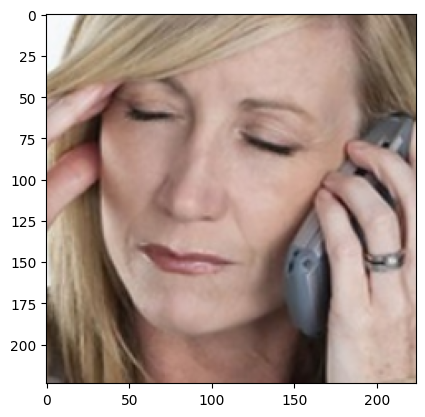

/home/ubuntu/anaconda3/envs/syn-torch1.10.1/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/ubuntu/rppg_synthetic/decalib/utils/util.py:266: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  vertices_faces = vertices.reshape((bs * nv, 3))[faces.long()]
/home/ubuntu/anaconda3/envs/syn-torch1.10.1/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corn

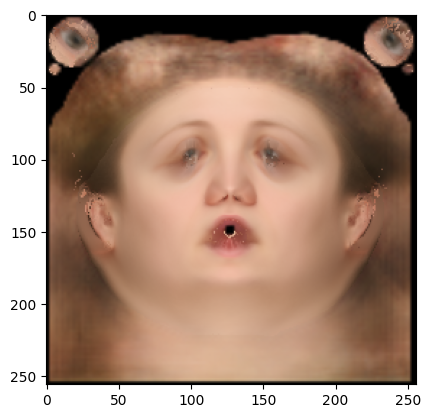

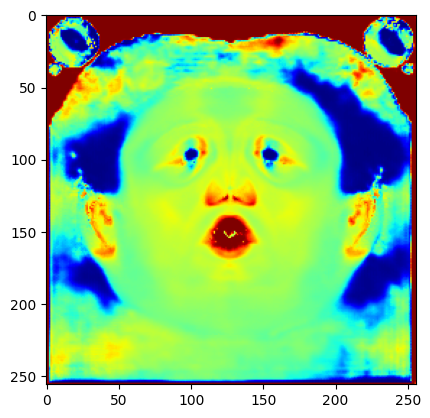

Duration:  44.93567109107971
(900, 128, 128, 3)


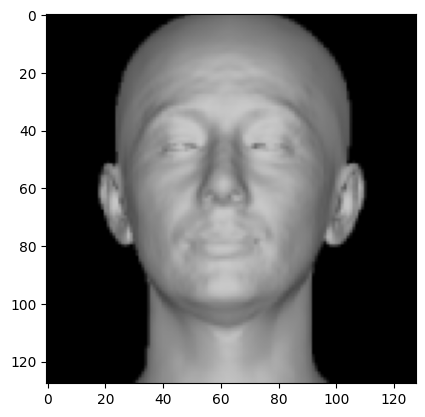

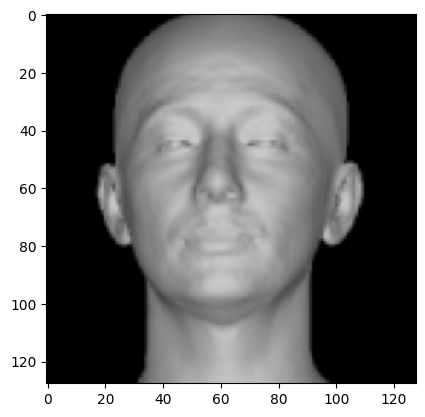

1
0.63636
alfw2


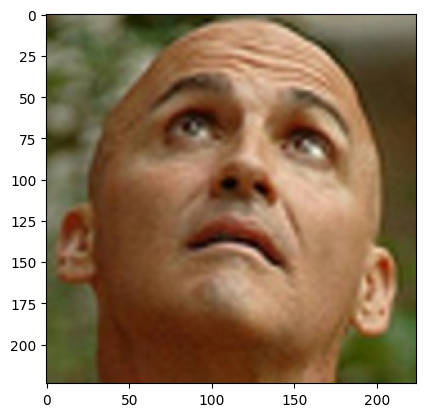

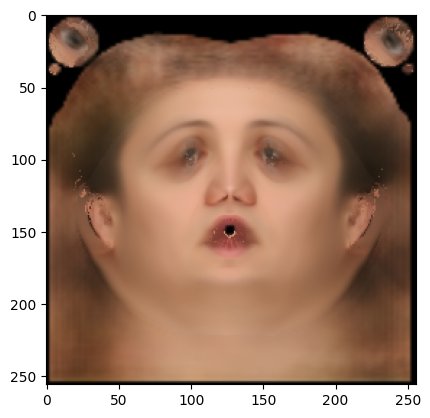

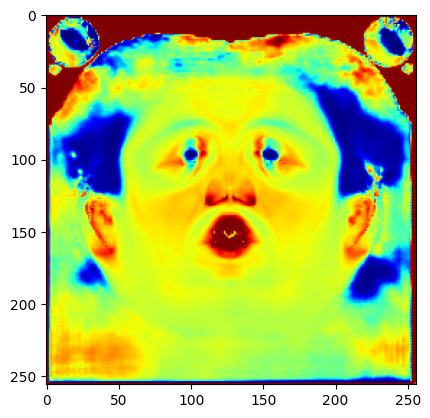

Duration:  77.18663573265076
(900, 128, 128, 3)


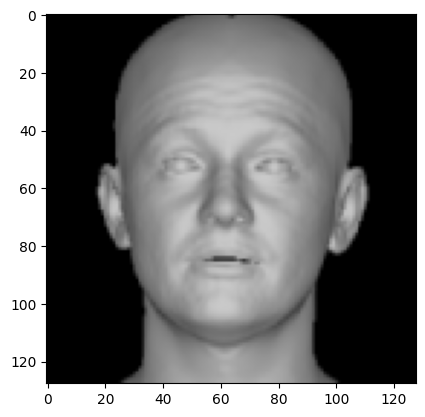

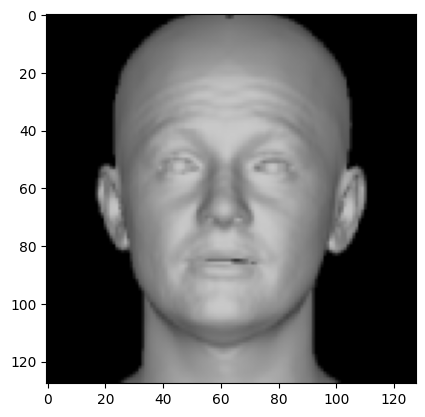

2
0.18866
id04657-PPHljWCZ53c-000565_inputs_inputs


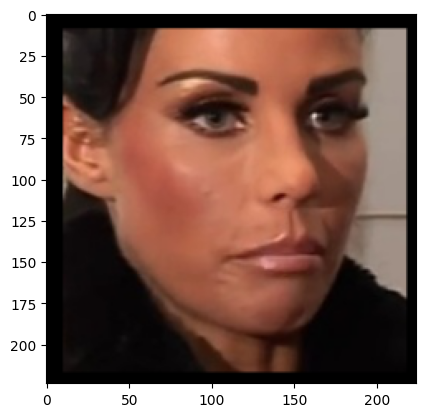

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


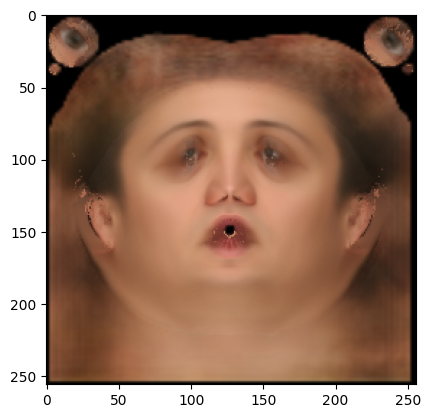

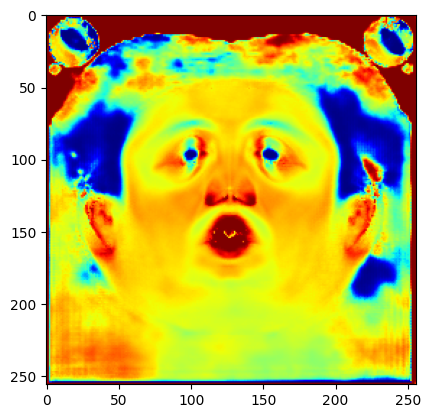

Duration:  109.46120619773865
(900, 128, 128, 3)


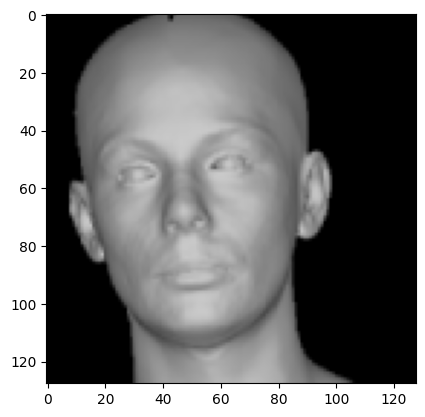

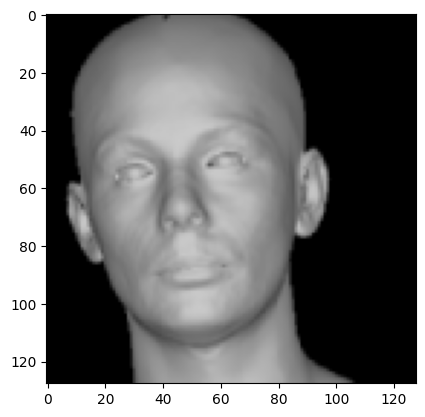

3
0.67253
id06692-Hlahj5abifM-002721_inputs_inputs


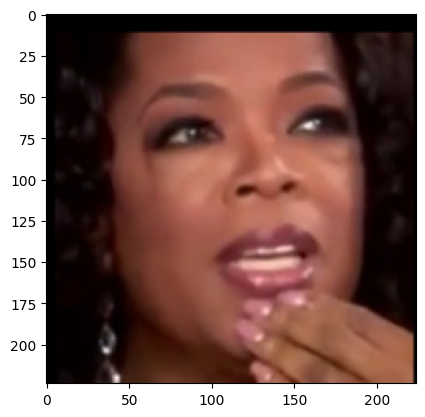

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


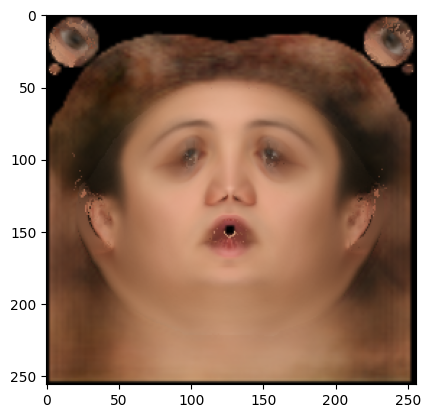

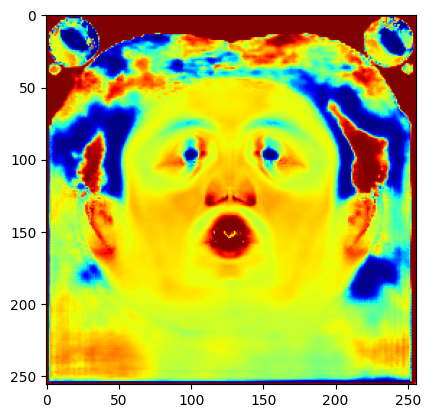

Duration:  141.71300792694092
(900, 128, 128, 3)


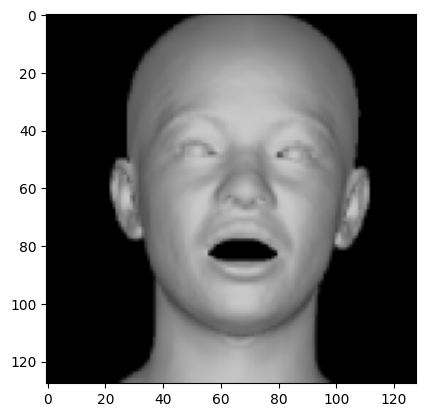

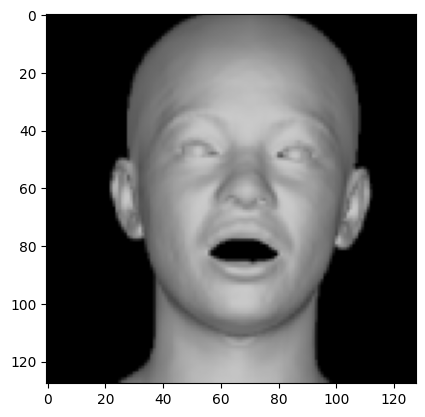

4
0.41642
id08392-DGGTJx470Ag-005451_inputs_inputs


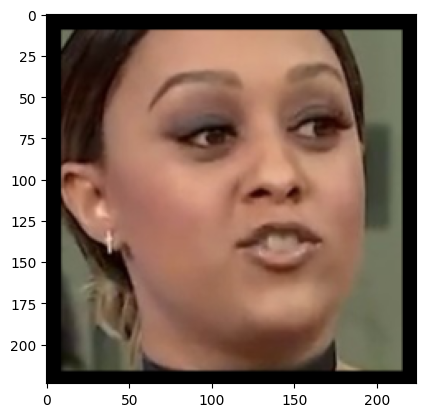

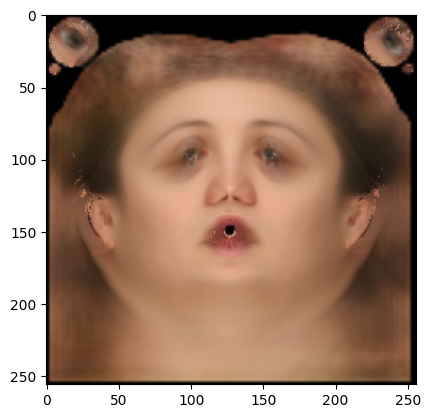

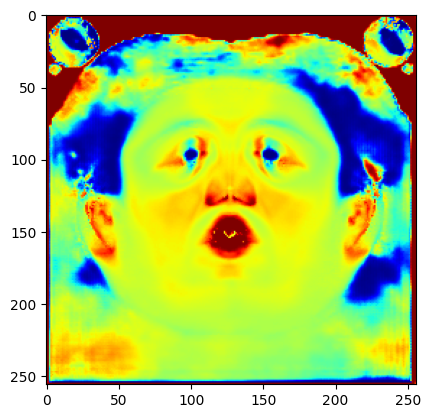

Duration:  174.0014386177063
(900, 128, 128, 3)


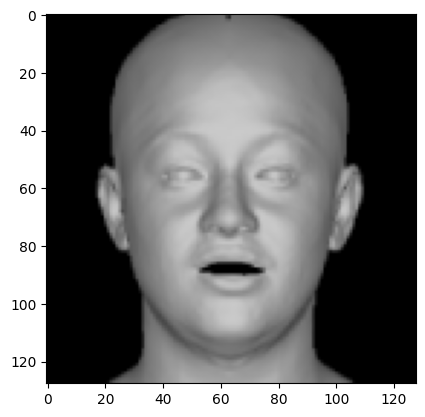

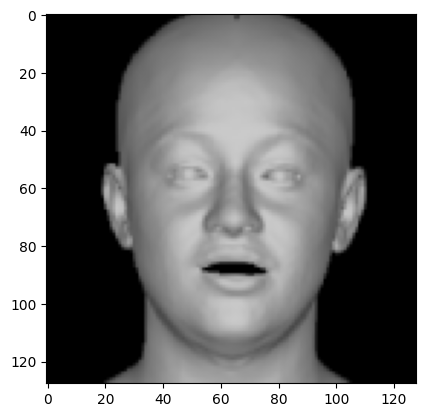

In [10]:
m_aap =  nn.AdaptiveAvgPool2d((128, 128)) #use adaptive avg pooling to downsample image to 80x80
import time
start = time.time()
def visualize(visdict, size=224, dim=2):
          assert dim == 1 or dim==2
          grids = {}
          for key in visdict:
              _,_,h,w = visdict[key].shape
              if dim == 2:
                  new_h = size; new_w = int(w*size/h)
              elif dim == 1:
                  new_h = int(h*size/w); new_w = size
              grids[key] = torchvision.utils.make_grid(F.interpolate(visdict[key], [new_h, new_w]).detach().cpu())
          grid = torch.cat(list(grids.values()), dim)
          grid_image = (grid.numpy().transpose(1,2,0).copy()*255)[:,:,[2,1,0]]
          grid_image = np.minimum(np.maximum(grid_image, 0), 255).astype(np.uint8)
          return grid_image

with torch.no_grad():
  # load test images 
  testdata = datasets.TestData(args['inputpath'], iscrop=args['iscrop'], face_detector=args['detector'])
  # expdata = datasets.TestData(args['exp_path'], iscrop=args['iscrop'], face_detector=args['detector'])
  
  for i in range(len(testdata)): 
    # try:
      # load image
      print(i)

      cur_ppg_path = os.path.join(PPG_wave_dir, 'bidmc_' + "{:02d}".format(i%53+1) + '_Signals.csv')
      ppg_file = pd.read_csv(cur_ppg_path)
      target = ppg_file[' PLETH'].values
      print(target[0])
      target_rppg = []

      for rppg_index in range(params['num_generated_frames']):
        target_rppg.append(target[int(rppg_index / 30 * 125)]) # 30hz downsampling
      target = np.array(target_rppg)
      lower_range = params['lower_range']
      upper_range = params['upper_range']

      ratio_to_first_frame = (target - target[0]) / (np.max(target) - np.min(target)) # in the range [-1, 1]
      ratio_to_first_frame = lower_range + \
                          (ratio_to_first_frame - (-1))/2 * (upper_range - lower_range)
      ratio_to_first_frame = torch.from_numpy(ratio_to_first_frame).unsqueeze(1).unsqueeze(2).float().to(device)

      name = testdata[i]['imagename']
      print(name)
      
      images = testdata[i]['image'].to(device)[None,...]
      
      # Show image
      show_img(images.cpu()[0].permute(1, 2, 0).numpy())
      images = images.repeat(params['batch_size'], 1, 1, 1)
      
      # images = m_upsample(images)
      # DECA fit
      codedict = deca.encode(images)
      opdict, visdict = deca.decode(codedict) #tensor
      albedo_uvmap = visdict['albedo']
      show_img(albedo_uvmap.cpu()[0].permute(1, 2, 0).numpy())
      # Prepare Biofacenet input
      albedo_uvmap_biofacenet = albedo_uvmap**2.2 - u.muim.view(-1,1,1)
      # albedo_uvmap_biofacenet = albedo_uvmap_biofacenet.repeat(64, 1, 1, 1)
      
      # Biofacenet fblood & fmel
      lightingparameters,b,fmel,fblood,predictedShading,specmask = model.predict(albedo_uvmap_biofacenet)
      
      # lightingparameters = lightingparameters.view(1, -1) # Add B dim
      # b = b.view(1, -1) # Add B dim
      weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,predictedShading,specmask = scalingNet(lightingparameters,b,fmel,fblood,predictedShading,specmask,u.bSize)
      
      
      # Show fmel & fblood
      show_img(cm.jet(0.5*(1+fblood[5]).detach().cpu().numpy())) 

      # Generate pose
      target_pose = 5 * torch.randn((1, 3))
      for k in range(params['num_generated_frames'] - 1):
        new_pose = target_pose[-1, :].view(1, 3) + torch.randn((1, 3))
        new_pose = torch.clamp(new_pose, -15, 15)
        target_pose = torch.cat((target_pose, new_pose), 0)

      # Generate expression
      target_exp = codedict['exp'][0:1]
      for k in range(params['num_generated_frames'] - 1):       
        new_exp = target_exp[-1, :].view(1, 50) + 0.03 * torch.randn((1, 50)).cuda()
        target_exp = torch.cat((target_exp, new_exp), 0)

      video_frame = []

      for batch_num in range(target.shape[0]//params['batch_size']): #
        # Edit fblood & fmel TODO: Add PPG
        # fmel = fmel + 0.01
        fmel = torch.clamp(fmel, -1, 1)

        fblood = fblood[0].unsqueeze(0).repeat(params['batch_size'], 1, 1) \
                    * ratio_to_first_frame[batch_num*params['batch_size']:batch_num*params['batch_size'] + params['batch_size']].repeat(1, 256, 256)
        fblood = torch.clamp(fblood, -1, 1)

        # Biofaceent reconstruct
        e = illuminationModel_modified(weightA,weightD,Fweights,CCT,u.illumA,u.illumDNorm,u.illumFNorm)
        Sr,Sg,Sb = cameraModel_modified(u.mu,u.PC,u.rgbCMF,b,u.wavelength)
        lightcolour = computelightcolour(e,Sr,Sg,Sb)
        Specularities = computeSpecularities(specmask,lightcolour)
        R_total = BiotoSpectralRef(fmel, fblood, u.Newskincolour)
        rawAppearance,diffuseAlbedo = ImageFormation(R_total, Sr,Sg,Sb,e,Specularities,predictedShading)
        ImwhiteBalanced = WhiteBalance(diffuseAlbedo,lightcolour)
        T_RAW2XYZ = findT(u.Tmatrix,BGrid)
        sRGBim = fromRawTosRGB(ImwhiteBalanced,T_RAW2XYZ,u.Txyzrgb)
        albedo_uvmap_modified = sRGBim**(1/2.2)

        # Edit pose
        euler_pose = target_pose[batch_num*params['batch_size']:batch_num*params['batch_size'] + params['batch_size'], :]
        global_pose = batch_euler2axis(deg2rad(euler_pose[:, :3].cuda()))
        codedict['pose'][:,:3] = global_pose
        codedict['cam'][:,:] = 0
        codedict['cam'][:,0] = 8

        # Edit expression
        codedict['exp'] = target_exp[batch_num*params['batch_size']:batch_num*params['batch_size'] + params['batch_size'], :]
        # print(codedict['exp'])

        # DECA decode
        _, visdict_view = deca.decode_modified(codedict, albedo_uvmap_modified)
        
        # reconstructed_img = m_aap(torch.clamp(visdict_view['rendered_images']*255, 0, 255))
        reconstructed_img = m_aap(torch.clamp(visdict_view['shape_detail_images']*255, 0, 255))
        

        if batch_num == 0:
          frame_saved = reconstructed_img.cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)       
        else:
          frame_saved = np.concatenate((frame_saved, reconstructed_img.cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)), 0)
      
      end = time.time()

      duration = end - start
      print("Duration: ", duration)
      print(frame_saved.shape)
      for i in range(frame_saved.shape[0]):
        show_img(frame_saved[i])
        if i == 1:
          break
      new_h5_name = name + '_bidmc_' + "{:02d}".format(i%53+1) + '_syn.h5'
      hf = h5py.File(os.path.join(params['generated_video_path'], new_h5_name), 'w')
      hf.create_dataset('dataset_1', data=frame_saved)
      hf.create_dataset('ppg', data=np.array(target))
      hf.close()
    # except Exception as e:
    #   print("error: ", e)